# Topology meets TPMS
## TPMS part

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv

count_pount = 100 # количество генерируемых точек для поверхности. В дальнейшем залаваемый параметр
 
def generate_points(count_pount):
    one_axis = np.linspace(-np.pi, np.pi, count_pount)
    xyz_mesh = np.meshgrid(one_axis, one_axis, one_axis)
    x,y,z = xyz_mesh
    return x,y,z
    

# генерация случайных чисел для парметра d
size = 30
np.random.seed(1999)
d_param = sorted(np.random.uniform(low=-0.99, high=0.99, size=size))
print(d_param)



def generate_tpms_Schwarz_p(d_param):
    x,y,z = generate_points(count_pount)
    
    porosity_list = []
    pointcloud_list = []
    
    for i in range(len(d_param)):
        Schwarz_p = np.cos(x) + np.cos(y) + np.cos(z) + d_param[i] #эт формула поверхности Шварца
        tolerance = 0.001
        x0,y0,z0 = np.where(abs(Schwarz_p)<tolerance)
        pointcloud = np.vstack((x0,y0,z0)).T
        cube_volume = (np.min(x0) + np.max(x0)) * (np.min(y0) + np.max(y0)) * (np.min(z0) + np.max(z0)) #Объем кубика
        cloud = pv.PolyData(pointcloud)
        surface = cloud.reconstruct_surface() # Облако точек для расчета объема
        surface_volume = surface.volume # Объем поверхности
        porosity = (cube_volume-surface_volume)/surface_volume #расчитываем удельную пористость
        porosity_list.append(porosity)
        pointcloud_list.append(pointcloud)
        
    return porosity_list, pointcloud_list

porosity_list_Schwarz_p, pointcloud_list_Schwarz_p = generate_tpms_Schwarz_p(d_param)

def generate_tpms_Gyroid(d_param):
    x,y,z = generate_points(count_pount)
    
    porosity_list = []
    pointcloud_list = []
    for i in range(len(d_param)):
        Gyroid = np.cos(x)*np.sin(y) + np.cos(y)*np.sin(z) + np.cos(z)*np.sin(x) + d_param[i] #эт формула поверхности Геройда
        tolerance = 0.001
        x0,y0,z0 = np.where(abs(Gyroid)<tolerance)
        pointcloud = np.vstack((x0,y0,z0)).T
        cube_volume = (np.min(x0) + np.max(x0)) * (np.min(y0) + np.max(y0)) * (np.min(z0) + np.max(z0)) #Объем кубика
        cloud = pv.PolyData(pointcloud)
        surface = cloud.reconstruct_surface() # Облако точек для расчета объема
        surface_volume = surface.volume # Объем поверхности
        porosity = (cube_volume-surface_volume)/surface_volume #расчитываем удельную пористость
        porosity_list.append(porosity)
        pointcloud_list.append(pointcloud)
    return porosity_list, pointcloud_list

porosity_list_Gyroid, pointcloud_list_Gyroid = generate_tpms_Gyroid(d_param)

[-0.9850857963678311, -0.8343366615126921, -0.7463244532435692, -0.602925211425586, -0.47958702941652886, -0.43776187070576, -0.41136858767030715, -0.35709910913454423, -0.35088529180876293, -0.32964127267370724, -0.2623206879754544, -0.08615109294964762, 0.18464827439927678, 0.27200298758254116, 0.4294859077816455, 0.44617777626215216, 0.4578855036043936, 0.465394608817425, 0.583935658785212, 0.6425499439208111, 0.6623205758437742, 0.7132291852184753, 0.7213150183216164, 0.7784261431370918, 0.8433895374071456, 0.8677782656328097, 0.873779300317322, 0.953246239519624, 0.9595609819109678, 0.9629671327983598]


## Topology part

In [29]:
import gudhi as gd
import plotly as pl
import plotly.graph_objs as gobj
import plotly.io as pio
pio.renderers.default = 'iframe'

In [30]:
def plot_diagram_giotto(diagram, homology_dimensions=None, plotly_params=None):
    """Plot a single persistence diagram.

    Parameters
    ----------
    diagram : ndarray of shape (n_points, 3)
        The persistence diagram to plot, where the third dimension along axis 1
        contains homology dimensions, and the first two contain (birth, death)
        pairs to be used as coordinates in the two-dimensional plot.

    homology_dimensions : list of int or None, optional, default: ``None``
        Homology dimensions which will appear on the plot. If ``None``, all
        homology dimensions which appear in `diagram` will be plotted.

    plotly_params : dict or None, optional, default: ``None``
        Custom parameters to configure the plotly figure. Allowed keys are
        ``"traces"`` and ``"layout"``, and the corresponding values should be
        dictionaries containing keyword arguments as would be fed to the
        :meth:`update_traces` and :meth:`update_layout` methods of
        :class:`plotly.graph_objects.Figure`.

    Returns
    -------
    fig : :class:`plotly.graph_objects.Figure` object
        Figure representing the persistence diagram.

    """
    # TODO: increase the marker size
    if homology_dimensions is None:
        homology_dimensions = np.unique(diagram[:, 2])

    diagram = diagram[diagram[:, 0] != diagram[:, 1]]
    diagram_no_dims = diagram[:, :2]
    posinfinite_mask = np.isposinf(diagram_no_dims)
    neginfinite_mask = np.isneginf(diagram_no_dims)
    max_val = np.max(np.where(posinfinite_mask, -np.inf, diagram_no_dims))
    min_val = np.min(np.where(neginfinite_mask, np.inf, diagram_no_dims))
    parameter_range = max_val - min_val
    extra_space_factor = 0.02
    has_posinfinite_death = np.any(posinfinite_mask[:, 1])
    if has_posinfinite_death:
        posinfinity_val = max_val + 0.1 * parameter_range
        extra_space_factor += 0.1
    extra_space = extra_space_factor * parameter_range
    min_val_display = min_val - extra_space
    max_val_display = max_val + extra_space

    fig = gobj.Figure()
    fig.add_trace(gobj.Scatter(
        x=[min_val_display, max_val_display],
        y=[min_val_display, max_val_display],
        mode="lines",
        line={"dash": "dash", "width": 1, "color": "black"},
        showlegend=False,
        hoverinfo="none"
        ))

    for dim in homology_dimensions:
        name = f"H{int(dim)}" if dim != np.inf else "Any homology dimension"
        subdiagram = diagram[diagram[:, 2] == dim]
        unique, inverse, counts = np.unique(
            subdiagram, axis=0, return_inverse=True, return_counts=True
            )
        hovertext = [
            f"{tuple(unique[unique_row_index][:2])}" +
            (
                f", multiplicity: {counts[unique_row_index]}"
                if counts[unique_row_index] > 1 else ""
            )
            for unique_row_index in inverse
            ]
        y = subdiagram[:, 1]
        if has_posinfinite_death:
            y[np.isposinf(y)] = posinfinity_val
        fig.add_trace(gobj.Scatter(
            x=subdiagram[:, 0], y=y, mode="markers",
            hoverinfo="text", hovertext=hovertext, name=name
        ))

    fig.update_layout(
        width=500,
        height=500,
        xaxis1={
            "title": "Birth",
            "side": "bottom",
            "type": "linear",
            "range": [min_val_display, max_val_display],
            "autorange": False,
            "ticks": "outside",
            "showline": True,
            "zeroline": True,
            "linewidth": 1,
            "linecolor": "black",
            "mirror": False,
            "showexponent": "all",
            "exponentformat": "e"
            },
        yaxis1={
            "title": "Death",
            "side": "left",
            "type": "linear",
            "range": [min_val_display, max_val_display],
            "autorange": False, "scaleanchor": "x", "scaleratio": 1,
            "ticks": "outside",
            "showline": True,
            "zeroline": True,
            "linewidth": 1,
            "linecolor": "black",
            "mirror": False,
            "showexponent": "all",
            "exponentformat": "e"
            },
        plot_bgcolor="white"
        )

    # Add a horizontal dashed line for points with infinite death
    if has_posinfinite_death:
        fig.add_trace(gobj.Scatter(
            x=[min_val_display, max_val_display],
            y=[posinfinity_val, posinfinity_val],
            mode="lines",
            line={"dash": "dash", "width": 0.5, "color": "black"},
            showlegend=True,
            name=u"\u221E",
            hoverinfo="none"
        ))

    # Update traces and layout according to user input
    if plotly_params:
        fig.update_traces(plotly_params.get("traces", None))
        fig.update_layout(plotly_params.get("layout", None))

    return fig

In [31]:
def gudhi_dgm_to_giotto(dgm):
    """
    Transforms Gudhi diagram to Giotto-TDA diagram representation
    """
    size = len(dgm)
    giotto_dgm = np.zeros((size,3))
    homologies = np.array([cycle[0] for cycle in dgm])
    giotto_dgm[:,-1] = homologies
    birth_death_info = np.array([cycle[1] for cycle in dgm])
    giotto_dgm[:,:-1] = birth_death_info
    return giotto_dgm

### Schwarz TPMSs

In [9]:
dgms = [None] * size
for i, pc in enumerate(pointcloud_list_Schwarz_p):
    ac = gd.AlphaComplex(points=pc)
    stree = ac.create_simplex_tree()
    dgm = stree.persistence()
    dgms[i] = dgm

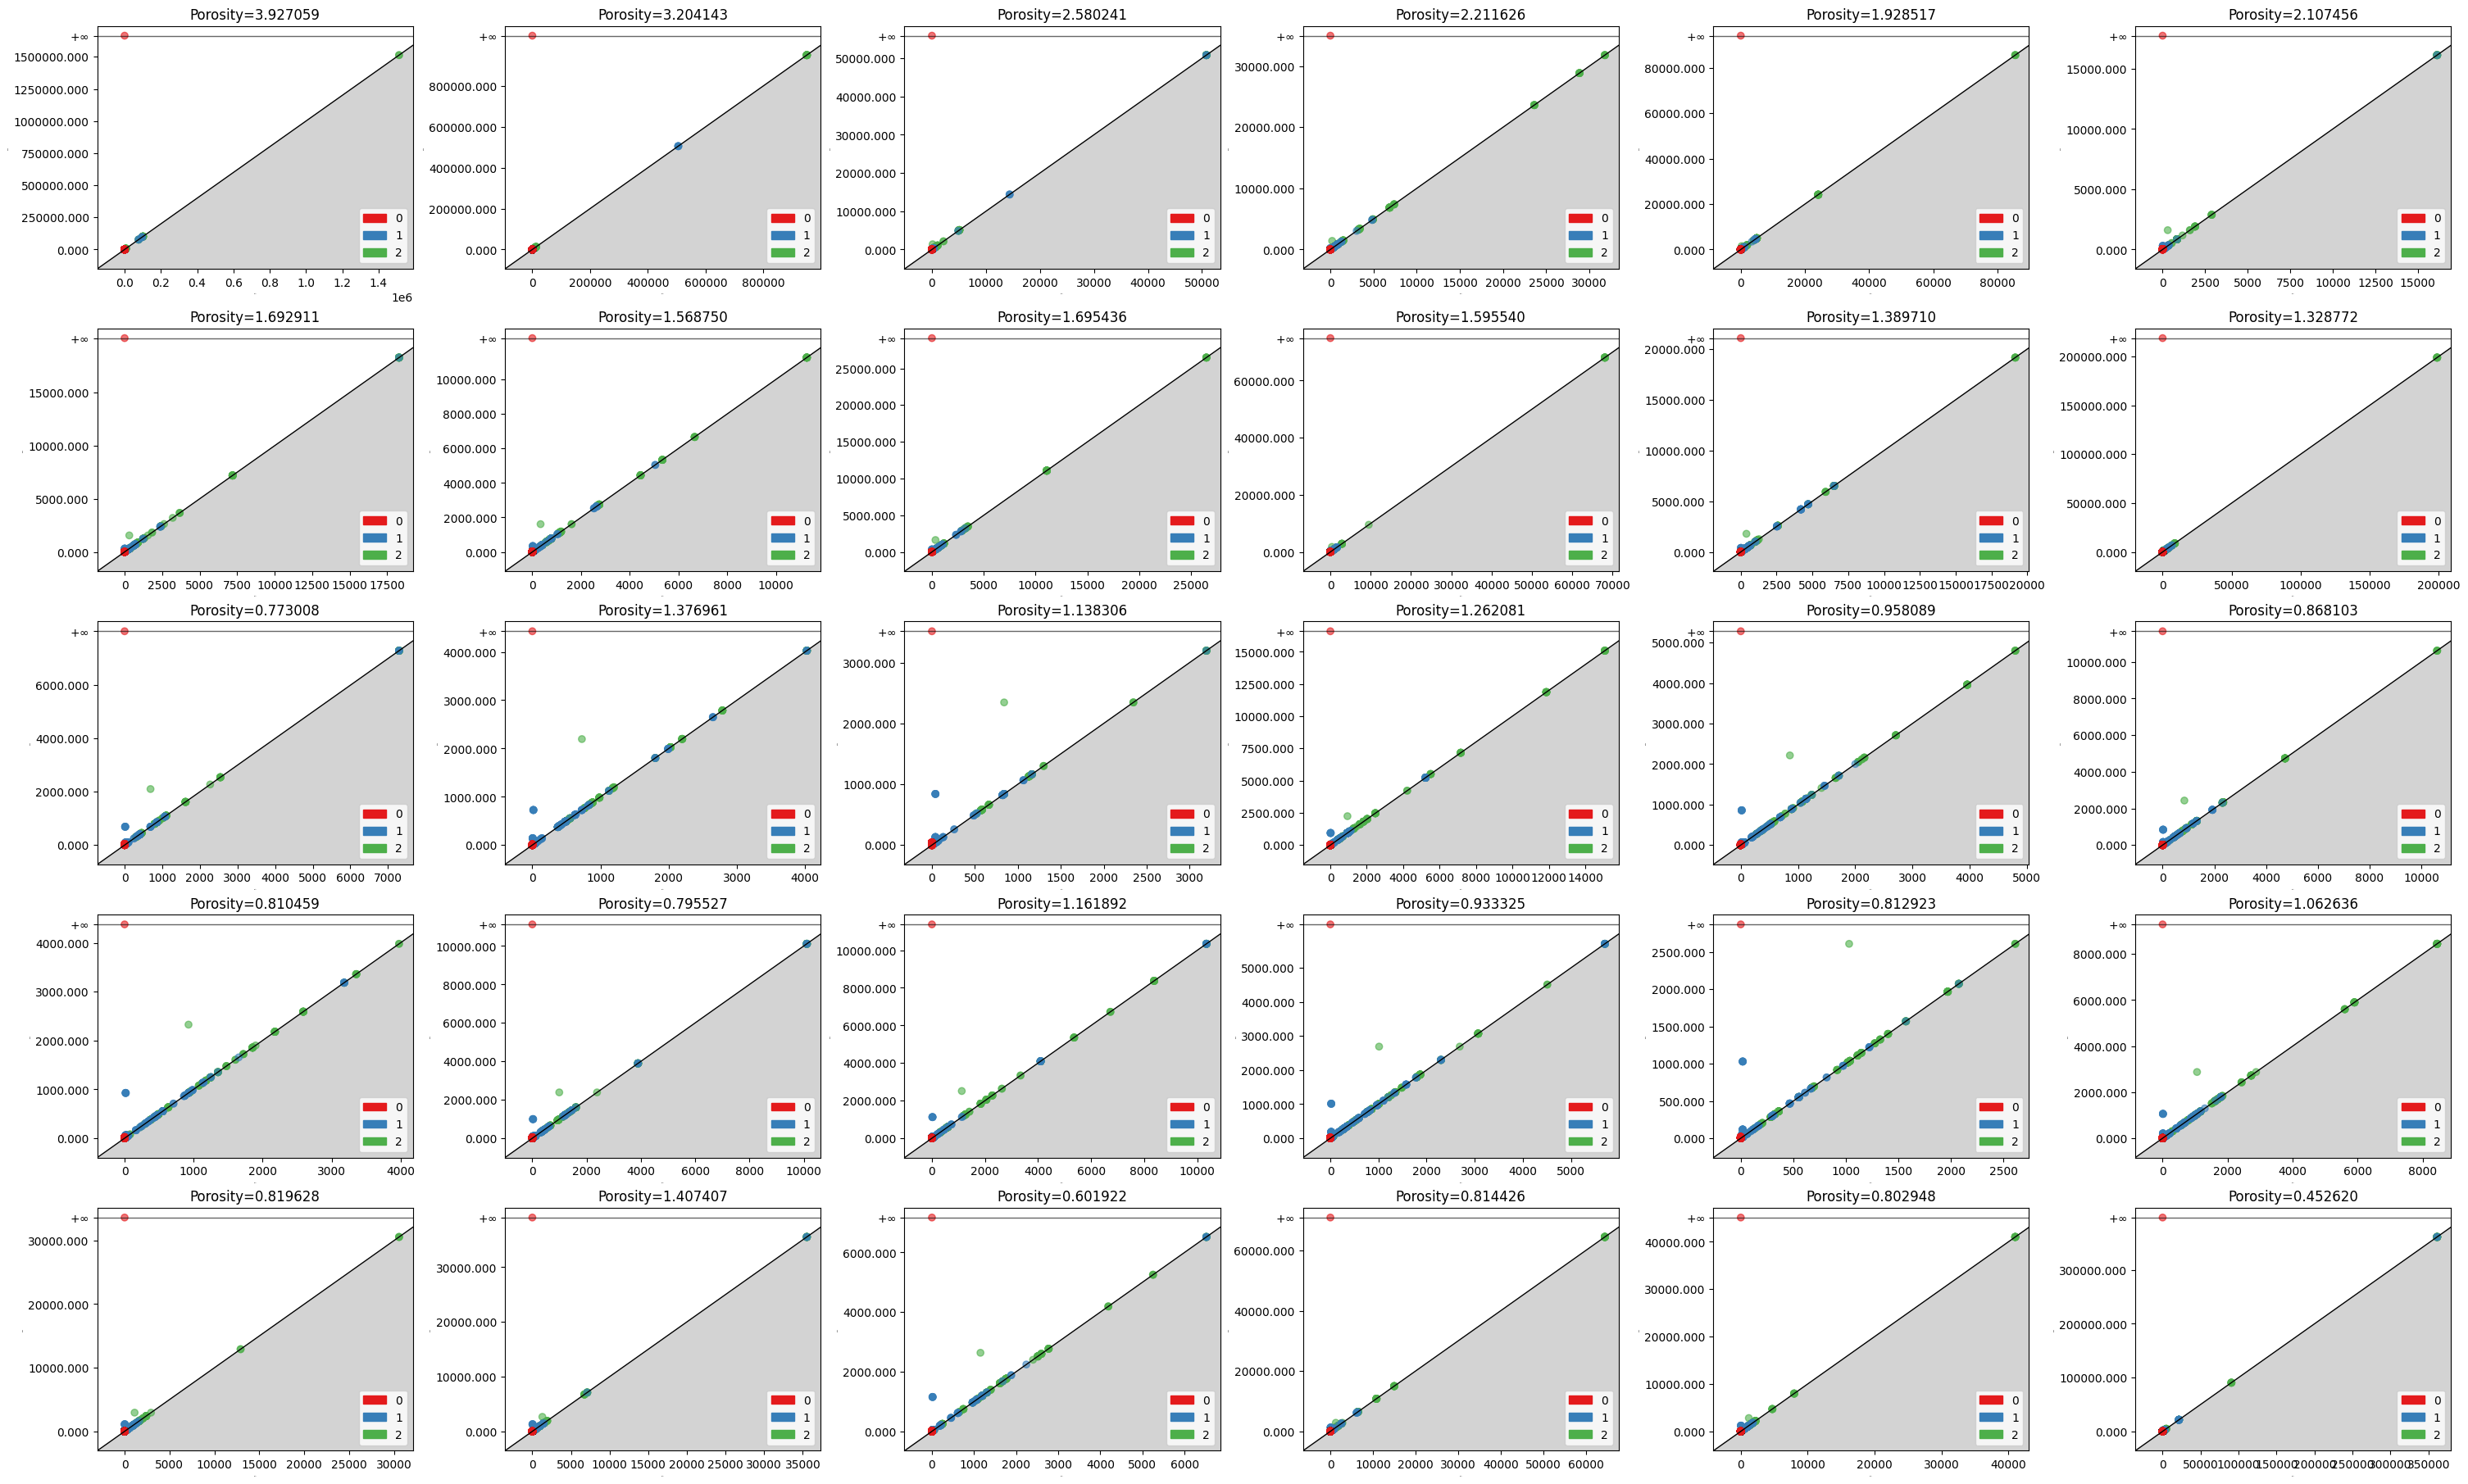

In [44]:
fig, axes = plt.subplots(figsize=(30,18), ncols=6, nrows=5, constrained_layout=True)
axes = axes.flatten()
for i in range(size):
    gd.plot_persistence_diagram(dgms[i], axes=axes[i], fontsize=0)
    axes[i].set_title(f"Porosity={porosity_list_Schwarz_p[i]:f}")

fig.savefig('Schwarz_pd_per_porosity.png')